### Notebook used to test the 3D contrucstion based on feature detection and depth stimation

To test it:
- Obtain Features of two frames
- Match the feature
- Stimate depth
- stimate pose

In [130]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [5]:
# READ IN ALL THE DATA
DATASET_PATH = "../data/final_project_2023_rect/"
DATASET_NOT_REC = "final_project_data/"

## Get the images
left_images = glob.glob(DATASET_PATH + "/seq_01/image_02/data/*.png")
right_images = glob.glob(DATASET_PATH + "/seq_01/image_03/data/*.png")
left_images.sort()
right_images.sort()

left_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_02/data/*.png")
right_images_not_rectified = glob.glob(DATASET_NOT_REC + "/seq_01/image_03/data/*.png")

maxTimeStep = len(right_images)
print(maxTimeStep)

old_disparity = new_disparity = None

145


In [6]:
def calculateQManually(p1, p2):
    """Function to calculate the disparity to depth mapping matrix Q manually
       based on the two camera matrices

    Args:
        p1 (ndarray): 3x4 camera matrix of the left camera
        p2 (ndarray): 3x4 camera matrix of the right camera

    Returns:
        Q: the depth-to-disparity matrix
    """    
    # f = 707.0493; tx = 0.54; cx1 = 601.6086; cy = 183.1104; cx2 = -334.1081
    f = p1[0,0]             # Calculate the focal length
    tx = 0.54         # Calculate the baseline
    cx1 = p1[0,2]
    cx2 = p2[0,2]
    cy =  p1[1,2]
    # Calculate the Q matrix
    Q = np.float32([[1, 0,  0,  -cx1],
                    [0, 1, 0,  -cy],
                    [0, 0,  0,     f],
                    [0, 0, -1/tx, (cx1-cx2)/tx]])
    return Q

In [7]:
def readAllColorMatrices():
    """Function to read all the interesting matrices in the calib_cam_to_cam.txt file

    Returns:
        matrices: all the relevant matrices for the colored images
    """    
    path = "../data/final_project_2023_rect/calib_cam_to_cam.txt"
    
    with open(path, 'r') as f:
        fin = f.readlines()
        for line in fin:
            if line[:4] == "R_02":
                rotation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "R_03":
                rotation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_02":
                intrinsic2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "K_03":
                intrinsic3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_02":
                translation2 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:4] == "T_03":
                translation3 = np.array(line[6:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "S_rect_02":
                imageSize2 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "S_rect_03":
                imageSize3 = np.array(line[11:].strip().split(" ")).astype('float32')
            elif line[:9] == "R_rect_02":
                rectRot2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "R_rect_03":
                rectRot3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_02":
                camMatrix2 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
            elif line[:9] == "P_rect_03":
                camMatrix3 = np.array(line[11:].strip().split(" ")).astype('float32').reshape(3,-1)
    
    return rotation2, rotation3, translation2, translation3, imageSize2, imageSize3, \
            rectRot2, rectRot3, camMatrix2, camMatrix3, intrinsic2, intrinsic3

In [95]:
def nothing(x):
    pass

def semiGlobalMatchMap(left_img, right_img):
    """Function using the SGMBM algorithm to compute the disparity map

    Args:
        left_img (ndarray): color image of the left camera
        right_img (ndarray): color image of the right camera

    Returns:
        stereo: the SGMBM object
        disparity: the disparity map
    """    
    
    cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('disp',800,800)
    
    ###### Default values ######
    blockSize = 11          # odd number, usually in range 3-11
    minDisparity = -1
    maxDisparity = 8       
    numDisparities = maxDisparity-minDisparity  # max disparity minus minDisparity, must be divisible by 16
    preFilterCap = 0
    uniquenessRatio = 1

    # affect the noise
    speckleRange = 1       # multiplied by 16 implicitly, 1 or 2 usually good
    speckleWindowSize = 54 # 50-200 range
    ###################
    
    cv2.createTrackbar('minDisparity','disp',minDisparity,17,nothing)
    cv2.createTrackbar('numDisparities','disp',numDisparities,17,nothing)
    cv2.createTrackbar('blockSize','disp',blockSize,20,nothing)
    cv2.createTrackbar('preFilterCap','disp',preFilterCap,62,nothing)
    cv2.createTrackbar('uniquenessRatio','disp',uniquenessRatio,10,nothing)
    cv2.createTrackbar('speckleRange','disp',speckleRange,5,nothing)
    cv2.createTrackbar('speckleWindowSize','disp',speckleWindowSize,250,nothing)
    
    # Creating an object of StereoBM algorithm
    leftMatcher = cv2.StereoSGBM_create()
    
    while True:
        
        # Updating the parameters based on the trackbar positions
        numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
        numDisparities = 16 if numDisparities == 0 else numDisparities
        blockSize = cv2.getTrackbarPos('blockSize','disp')
        preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
        preFilterCap = 1 if preFilterCap == 0 else preFilterCap
        if blockSize % 2 == 0:
            blockSize += 1

        if blockSize < 5:
            blockSize = 5

        uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
        speckleRange = cv2.getTrackbarPos('speckleRange','disp')
        speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')
        minDisparity = cv2.getTrackbarPos('minDisparity','disp')
            
        # Setting the updated parameters before computing disparity map
        leftMatcher.setNumDisparities(numDisparities)
        leftMatcher.setBlockSize(blockSize)
        leftMatcher.setUniquenessRatio(uniquenessRatio)
        leftMatcher.setSpeckleRange(speckleRange)
        leftMatcher.setSpeckleWindowSize(speckleWindowSize)
        leftMatcher.setMinDisparity(minDisparity)
        # P1 and P2 values from OpenCV documentation
        leftMatcher.setP1(8*3*blockSize**2)
        leftMatcher.setP2(32*3*blockSize**2)
        
        # Calculating disparity using the stereoBM algorithm
        leftDisparity =  leftMatcher.compute(left_img, right_img).astype(np.float32)
        distL = cv2.ximgproc.getDisparityVis(leftDisparity)

        # Displaying the disparity map
        cv2.imshow("disp",distL)
    
        # Close window using esc key
        if cv2.waitKey(1) == 27:
            break 
    cv2.destroyAllWindows()
    return leftMatcher, distL

In [134]:
def export_pointcloud(disparity_map, colors, filename):

    def write_ply(fn, verts, colors):
        ply_header = '''ply
        format ascii 1.0
        element vertex %(vert_num)d
        property float x
        property float y
        property float z
        property uchar red
        property uchar green
        property uchar blue
        end_header
        '''
        colors = colors.copy()
        verts = verts.reshape(-1, 3)
        verts = np.hstack([verts, colors])
        with open("pointclouds/"+fn, 'wb') as f:
            f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
            np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
    
    rot2, rot3, trans2, trans3, imgSize2, imgSize3, rectRot2, rectRot3,\
    cam2, cam3, k2, k3 = readAllColorMatrices()
    # Q = calculateQManually(cam2, cam3)        # We let opencv calculate the Q matrix
    
    cam2 = cam2[:,:3]
    cam3 = cam3[:,:3]
    Tmat = np.array([0.54, 0.0, 0.0])   # From the KITTI Sensor setup, in metres 
    cvQ = np.zeros((4,4))
    cv2.stereoRectify(cameraMatrix1=cam2, cameraMatrix2=cam3, distCoeffs1=0, distCoeffs2=0,
                        imageSize=colors.shape[:2], R=np.identity(3), T=Tmat, 
                        R1=None, R2=None,P1=None, P2=None, Q=cvQ)
    
    points = cv2.reprojectImageTo3D(disparity_map, cvQ, handleMissingValues=False)
    #reflect on x axis
    reflect_matrix = np.identity(3)
    reflect_matrix[0] *= -1
    points = np.matmul(points,reflect_matrix)
    
    colors = cv2.cvtColor(colors, cv2.COLOR_BGR2RGB) # Extract colors from image
    mask = disparity_map > disparity_map.min()
    out_points = points[mask]
    out_colors = colors[mask]
    
    #filter by dimension
    idx = np.fabs(out_points[:,0]) < 4.5
    out_points = out_points[idx]
    out_colors = out_colors.reshape(-1, 3)
    out_colors = out_colors[idx]

    write_ply(filename, out_points, out_colors)
    print(f'{filename} saved')
    return out_points, reflect_matrix, idx, cam3, mask

In [10]:
def pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img):
    # Verify the pointcloud by going back to the original image based on the points
    reflected_pts = np.matmul(points, reflectMat)
    projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                            cam3[:3,:3], np.array([0., 0., 0., 0.]))
    projected_img = projected_img.reshape(-1, 2)

    blank_img = np.zeros(left_img.shape, 'uint8')
    img_colors = right_img[mask][idx].reshape(-1,3)

    for i, pt in enumerate(projected_img):
        pt_x = int(pt[0])
        pt_y = int(pt[1])
        if pt_x > 0 and pt_y > 0:
            # use the BGR format to match the original image type
            col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
            cv2.circle(blank_img, (pt_x, pt_y), 1, col)
    return blank_img

In [100]:
#Quite decent parameters saved here for the stereoSGBM
# minDisparity:  17
# numDisparities:  6.0
# blockSize:  7
# preFilterCap:  0
# uniquenessRatio:  0
# speckleRange:  2
# speckleWindowSize:  0
# P1:  1176
# P2:  4704

In [131]:
frame = 1
left_img = cv2.imread(left_images[frame])
right_img = cv2.imread(right_images[frame])
# Blur det images to reduce noise for the stereo matching
left_img_blur = cv2.blur(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY), (5,5))
right_img_blur = cv2.blur(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY), (5,5))

In [120]:
sgbmObject, disparityMap = semiGlobalMatchMap(left_img_blur, right_img_blur)

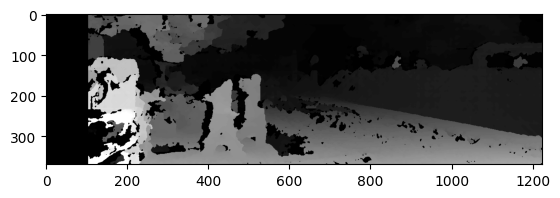

In [121]:
plt.imshow(disparityMap, "gray")

In [58]:
# For the "default" untuned parameters
# leftMatcher = cv2.StereoSGBM_create(numDisparities=96, blockSize=13)

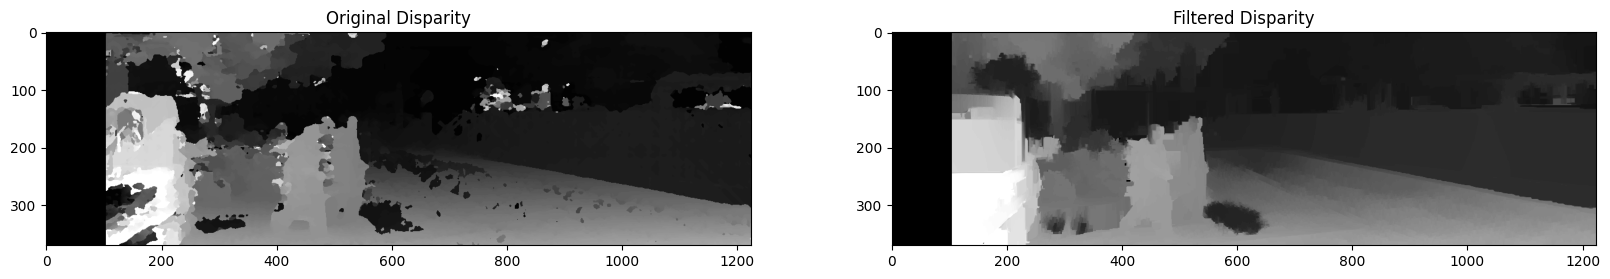

In [132]:
# Calculate the disparity map and apply WLS filter
leftMatcher = sgbmObject
rightMatcher = cv2.ximgproc.createRightMatcher(leftMatcher)

# Calculating disparity using the stereoBM algorithm
leftDisparity =  leftMatcher.compute(left_img_blur, right_img_blur)
rightDisparity = rightMatcher.compute(right_img_blur, left_img_blur)

# Create a WLS (weighted least squares) filter (source: https://docs.opencv.org/3.4/d3/d14/tutorial_ximgproc_disparity_filtering.html) 
wlsFilter = cv2.ximgproc.createDisparityWLSFilter(leftMatcher)
wlsFilter.setLambda(8000)     # The tuning parameter, depends on the range of disparity values
wlsFilter.setSigmaColor(0.7)    # Adjusts the filter's sensitivity to edges in the image (between 0.8 and 2.0 usually good)
filteredDisparity = wlsFilter.filter(leftDisparity, left_img_blur, None, rightDisparity)

# Get the original and filtered disparity images
orgDistL = cv2.ximgproc.getDisparityVis(leftDisparity)
filteredL = cv2.ximgproc.getDisparityVis(filteredDisparity)

# Visualize the images one above the other
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(orgDistL, 'gray')
plt.title('Original Disparity')
plt.subplot(222)
plt.imshow(filteredL, 'gray')
plt.title('Filtered Disparity')
plt.show()

In [99]:
print("__Current Parameters__")
print("minDisparity: ", sgbmObject.getMinDisparity())
print("numDisparities: ", sgbmObject.getNumDisparities()/16)
print("blockSize: ", sgbmObject.getBlockSize())
print("preFilterCap: ", sgbmObject.getPreFilterCap())
print("uniquenessRatio: ", sgbmObject.getUniquenessRatio())
print("speckleRange: ", sgbmObject.getSpeckleRange())
print("speckleWindowSize: ", sgbmObject.getSpeckleWindowSize())
print("P1: ", sgbmObject.getP1())
print("P2: ", sgbmObject.getP2())

__Current Parameters__
minDisparity:  17
numDisparities:  6.0
blockSize:  7
preFilterCap:  0
uniquenessRatio:  0
speckleRange:  2
speckleWindowSize:  0
P1:  1176
P2:  4704


pointcloud_Filter1.ply saved


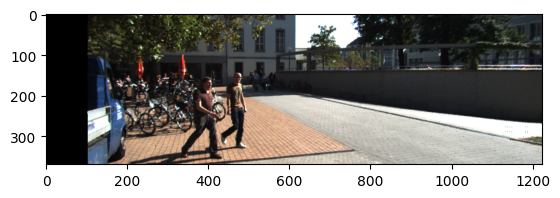

In [135]:
points, reflectMat, idx, cam3, mask = export_pointcloud(filteredDisparity, left_img, "pointcloud_Filter1.ply")
blank_img_filter = pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img)
plt.imshow(blank_img_filter, 'gray')

## Notice how above picture is perfectly put back together

In [271]:
# Fetch the saved disparity map
# recentDisp = dispMap.copy()
stereo = cv2.StereoSGBM_create(numDisparities=96, blockSize=11)
recentDisp = stereo.compute(left_img_blur, right_img_blur)
points, reflectMat, idx, cam3, mask = export_pointcloud(recentDisp, left_img, "pointcloud.ply")

/tmp/ipykernel_12159/1789186022.py:38: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points,reflect_matrix)


pointcloud.ply saved


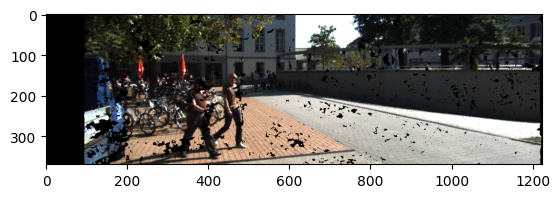

In [272]:
blank_img = pointcloudToImage(points, reflectMat, idx, cam3, mask, left_img, right_img)
plt.imshow(blank_img, 'gray')

# Create RGBD images?